In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

In [3]:
def convertStreak(streak):
    # N is post season?
    if streak == "N":
        return float('Nan')
    sign = -1 if streak[0] == "-" else 1
    return len(streak) * sign

def getDateConverter(year):
    def convertDate(date):
        # Handle duplicate headers
        if date == 'Date':
            return None
        
        # Remove double-header indication (1), (2) and convert to date
        d = datetime.datetime.strptime(re.sub(r'\s\(.*\)', '', date) + ' ' + str(year), '%A %b %d %Y')
        #d.year = year
        return datetime.date(d.year, d.month, d.day)
    
    return convertDate

def convertWL(wl):
    # Covert the W/L column to numeric
    if wl and wl[0] == 'W':
        return 1
    return 0

def readGameLog(csv, convertDate):
    df = pd.read_csv(csv, skip_blank_lines=True, converters={'Streak': convertStreak, 'Date': convertDate, 'W/L': convertWL})
    
    # Remove the headers in the middle of the file and postseason
    df = df.drop(df.index[
        (df.Rk == "Rk") | # Drop header rows
        np.isnan(df.Streak) # Post Season
    ])
    
    #print [d.days for d in np.diff(df.Date)]
    
    # First game in double headers
    df = df.drop(df.index[(np.append([d.days for d in np.diff(df.Date)], [1]) == 0)])
    
    return df

In [51]:
df1 = readGameLog("teams_BOS_2013-schedule-scores_team_schedule.csv", getDateConverter(2013))
df2 = readGameLog("teams_BOS_2014-schedule-scores_team_schedule.csv", getDateConverter(2014))
df3 = readGameLog("teams_BOS_2015-schedule-scores_team_schedule.csv", getDateConverter(2015))
df = pd.concat([df1, df2, df3], ignore_index=True)

In [52]:
df.columns

Index([u'Rk', u'Gm#', u'Date', u'Unnamed: 3', u'Tm', u'Unnamed: 5', u'Opp',
       u'W/L', u'R', u'RA', u'Inn', u'W-L', u'Rank', u'GB', u'Win', u'Loss',
       u'Save', u'Time', u'D/N', u'Attendance', u'Streak'],
      dtype='object')

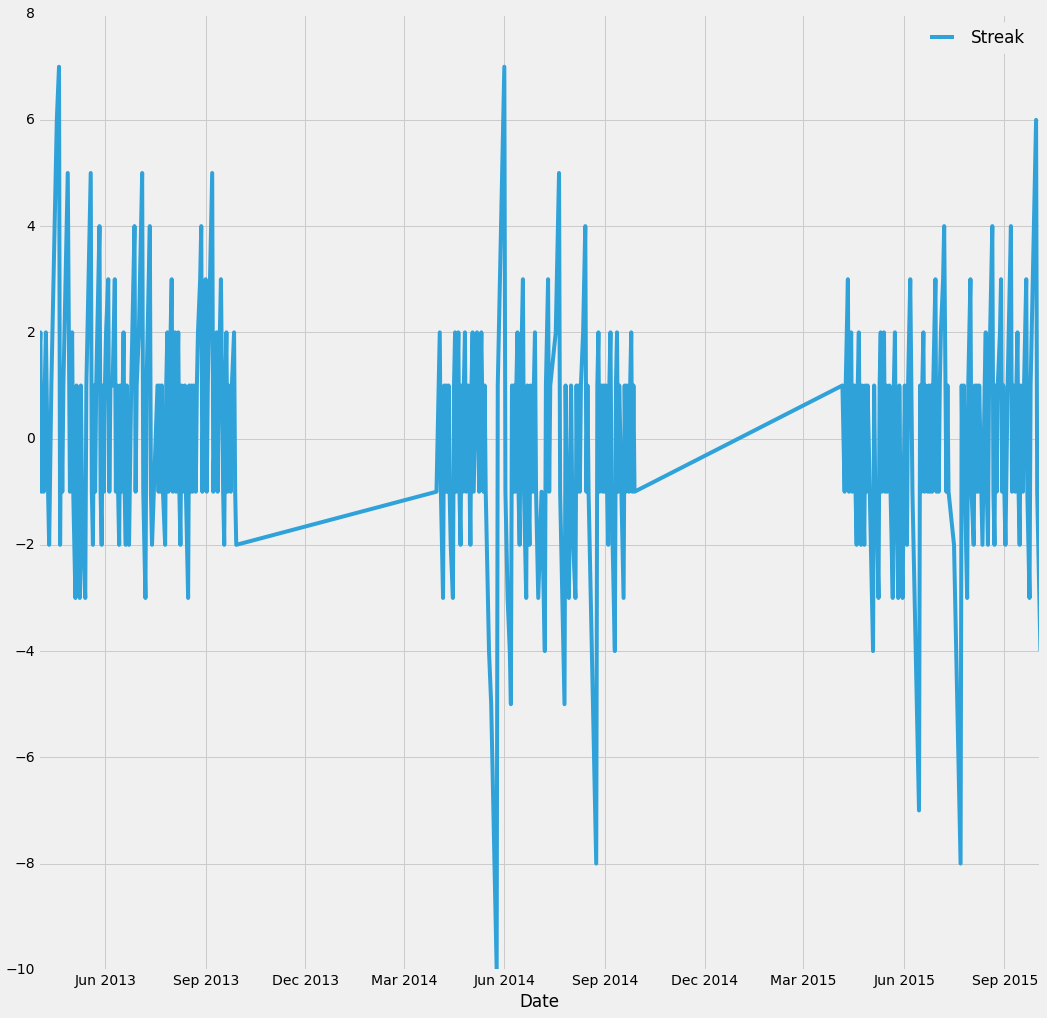

In [54]:
df.plot('Date', 'Streak', figsize=(16,16))

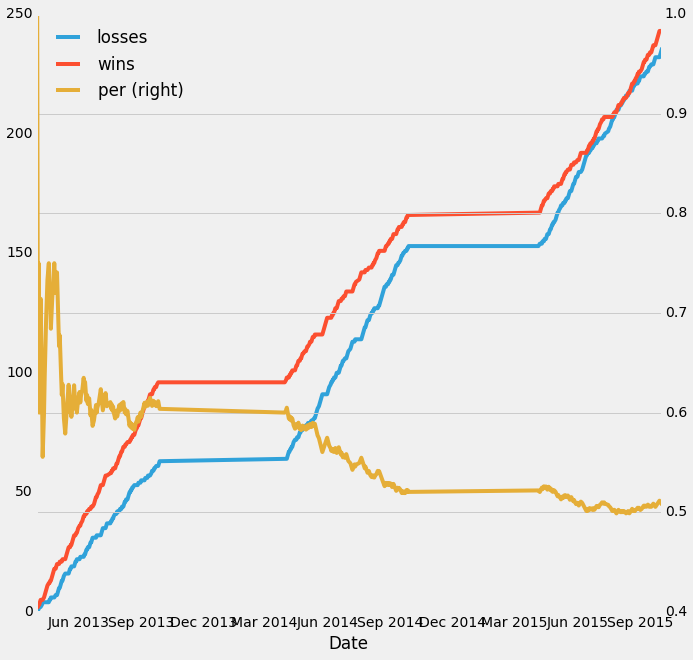

In [55]:
df['wins'] = np.cumsum(df['W/L'] == 1)
df['losses'] = np.cumsum(df['W/L'] == 0)
df['per'] = df['wins'] / (df['wins'] + df['losses'])
figure, ax = pl.subplots(figsize=(10,10))
df.plot('Date', 'losses', ax=ax)
df.plot('Date', 'wins', ax=ax)
df.plot('Date', 'per', ax=ax, secondary_y=True)

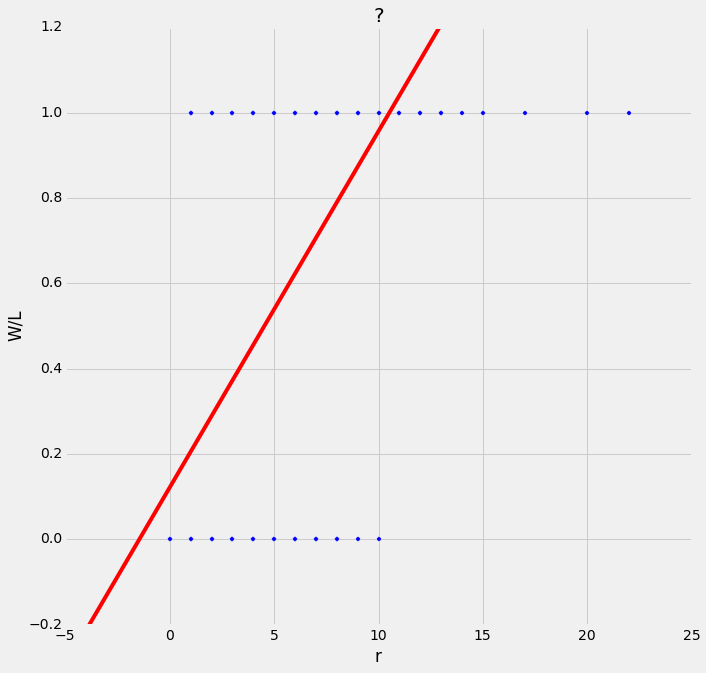

In [56]:
df['r'] = df.R.astype(int)
figure, ax = pl.subplots(figsize=(10,10))
df.plot('r', 'W/L', kind='scatter', ax=ax)
df['wl'] = df['W/L']
mod = smf.ols(formula='wl ~ r', data = df).fit()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('?')

In [57]:
def convertDate(d):
    date = datetime.datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p')
    return datetime.date(date.year, date.month, date.day)

In [58]:
crimes = pd.read_csv('Crime_Incident_Reports.csv', converters={'FROMDATE': convertDate})

In [13]:
crimes.columns

Index([u'COMPNOS', u'NatureCode', u'INCIDENT_TYPE_DESCRIPTION',
       u'MAIN_CRIMECODE', u'REPTDISTRICT', u'REPORTINGAREA', u'FROMDATE',
       u'WEAPONTYPE', u'Shooting', u'DOMESTIC', u'SHIFT', u'Year', u'Month',
       u'DAY_WEEK', u'UCRPART', u'X', u'Y', u'STREETNAME', u'XSTREETNAME',
       u'Location'],
      dtype='object')

In [62]:
#crimes.groupby('FROMDATE').count()
#crimes['FROMDATE'] = pd.to_datetime(crimes['FROMDATE'], format='%m/%d/%Y %I:%M:%S %p')
#crimes.FROMDATE
crimes = crimes.rename(columns = {'FROMDATE': 'Date'})

In [63]:
groups = crimes.groupby('Date')
counts = groups.count()['NatureCode']

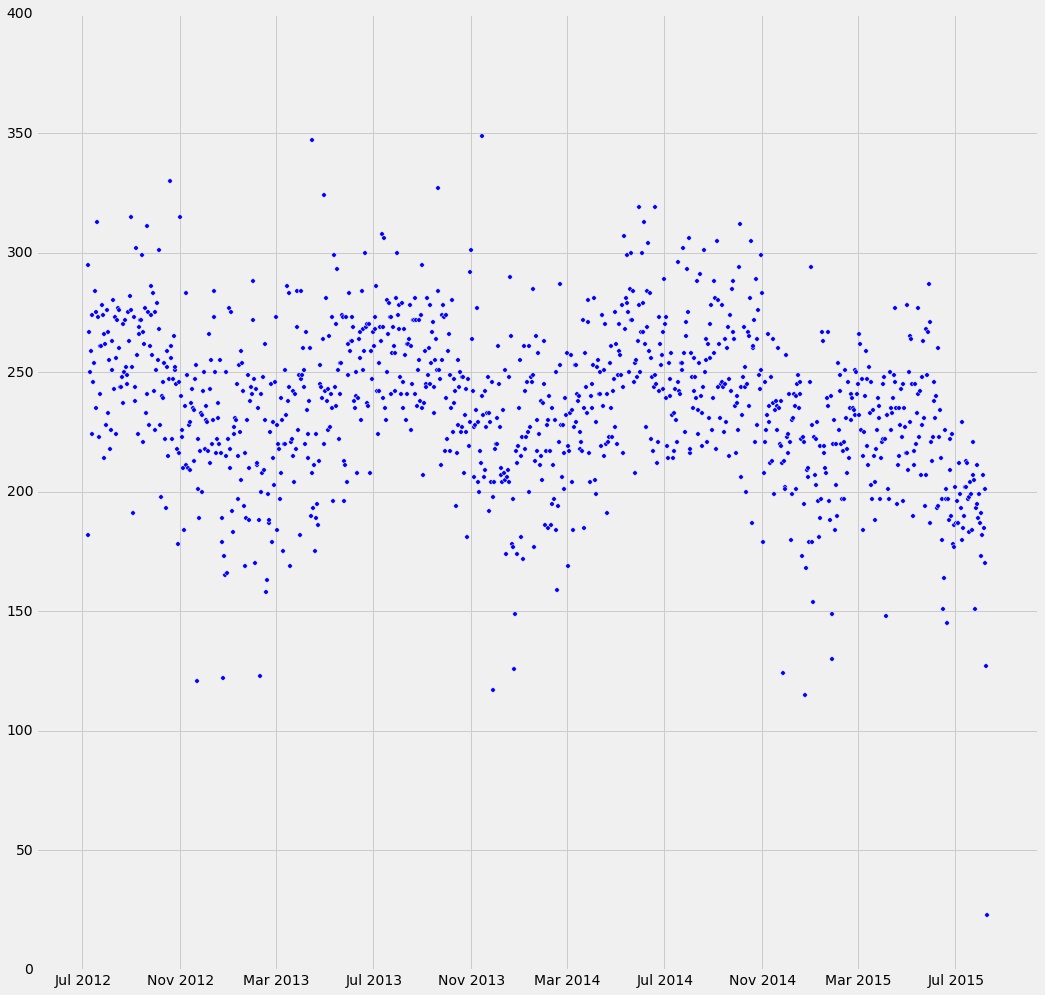

In [64]:
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(crimes.Date.unique(), counts)

In [65]:
merged = pd.merge(df, crimes, on='Date')

In [66]:
grouped = merged.groupby('Date')

In [67]:
streak = []
counts = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    counts.append(grouped.get_group(d).count()['NatureCode'])
print streak
print counts

[1, 2, -1, 1, -1, 1, 2, -1, -2, 1, 2, 3, 4, 5, 6, 7, -2, 1, -1, 1, 2, 3, 4, 5, -1, 1, 2, -1, -2, -3, 1, -1, -2, -3, 1, -1, -2, -3, 1, 2, 3, 4, 5, -1, -2, 1, -1, 1, 2, 3, 4, -1, -2, 1, -1, 1, 2, 3, -1, 1, 1, 2, 3, -1, 1, -1, -2, 1, -1, 2, -1, -2, 1, -1, -2, 1, 2, 3, 4, -1, 1, 2, 3, 4, 5, -1, -2, -3, 1, 2, 3, 4, -1, -2, 1, -1, 1, -1, 1, -1, -2, 1, 2, -1, 1, 2, 3, -1, 1, 2, -1, 1, 2, -1, -2, 1, -1, 1, -1, -2, -3, 1, -1, 1, -1, 1, -1, 1, 2, 3, 4, -1, 1, 2, 3, -1, 1, 2, 3, 4, 5, -1, 1, 2, -1, 1, 2, 3, -1, -2, 1, 2, -1, 1, -1, 1, 2, -1, -2, -1, 1, 2, -1, -2, -3, 1, -1, 1, -1, 1, -1, -2, -3, 1, 2, -1, 1, 2, -1, -2, 1, -1, 1, 2, -1, 1, -2, 1, 2, -1, 1, 2, -1, 1, 2, -1, 1, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, 1, 2, 3, 4, 5, 6, 7, -1, -2, -3, -4, -5, 1, -1, 1, -1, 1, 2, -1, -2, 1, 2, 3, -1, -2, -3, 1, -1, -2, 1, -1, 1, 2, -1, -2, -3, -1, -2, -3, -4, 1, 2, 3, -1, 1, 2, 3, 4, 5, -1, -2, -3, -4, -5, 1, -1, -2, -3, 1, -1, -2, -3, 1, -1, 1, -1, 1, 2, 3, 4, -1, 1, -1, -2, -3, -4, -5, -6, -7, -8, 1

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4839
Date:                Thu, 29 Oct 2015   Prob (F-statistic):              0.487
Time:                        13:51:17   Log-Likelihood:                -2096.7
No. Observations:                 429   AIC:                             4197.
Df Residuals:                     427   BIC:                             4206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    242.6411      1.554    156.153      0.0

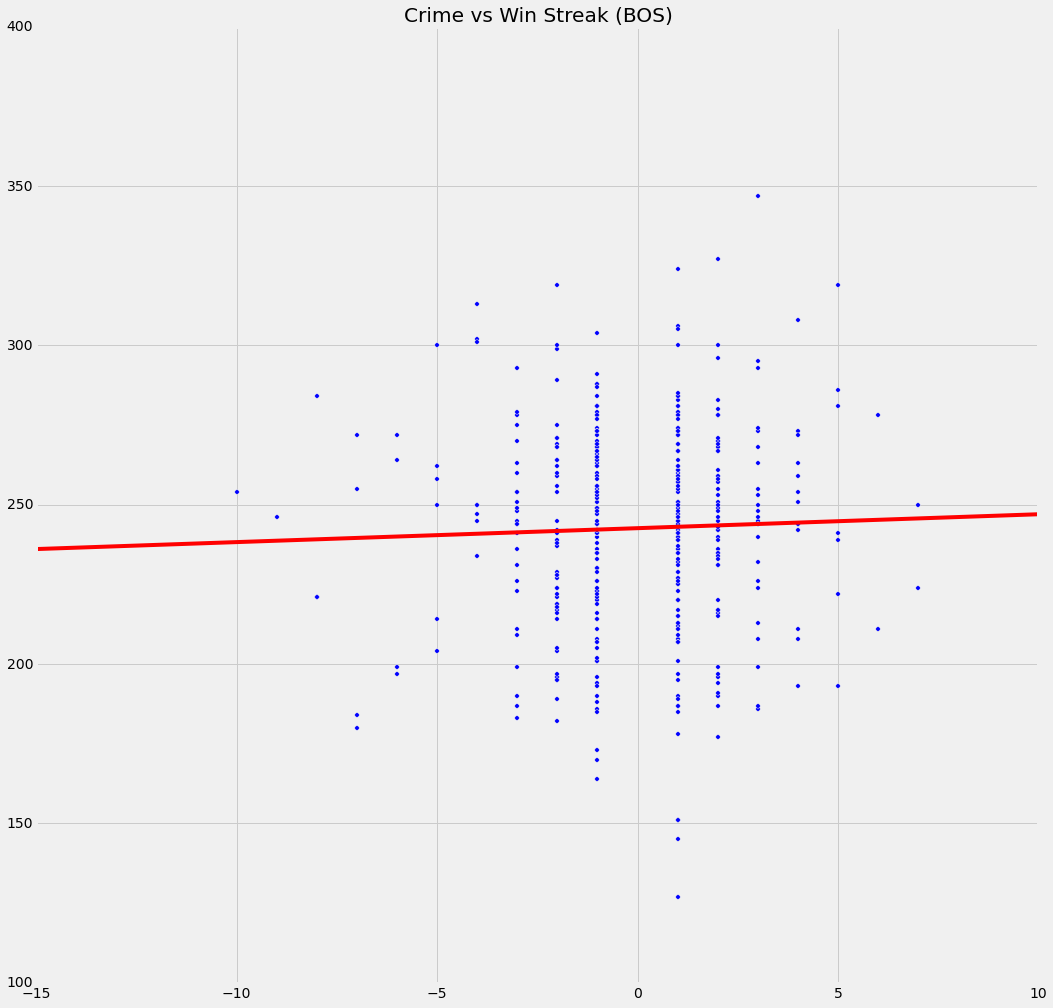

In [68]:
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('Crime vs Win Streak (BOS)')

In [69]:
df['Date'] = df.Date + datetime.timedelta(days=1)

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7511
Date:                Thu, 29 Oct 2015   Prob (F-statistic):              0.387
Time:                        13:51:40   Log-Likelihood:                -2117.7
No. Observations:                 429   AIC:                             4239.
Df Residuals:                     427   BIC:                             4248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    242.2291      1.632    148.426      0.0

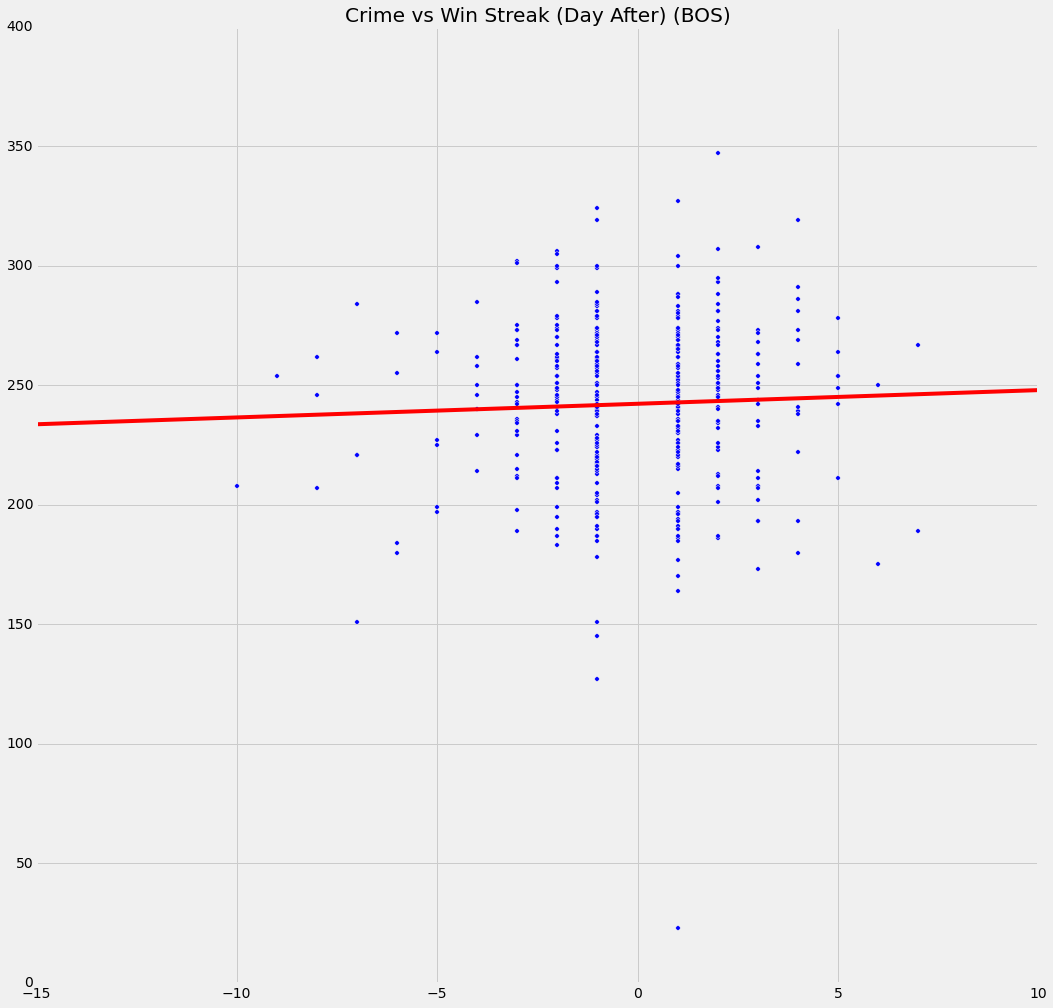

In [70]:
merged = pd.merge(df, crimes, on='Date')
grouped = merged.groupby('Date')
streak = []
counts = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    counts.append(grouped.get_group(d).count()['NatureCode'])
    
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('Crime vs Win Streak (Day After) (BOS)')

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1040
Date:                Thu, 29 Oct 2015   Prob (F-statistic):              0.747
Time:                        13:52:06   Log-Likelihood:                -2118.1
No. Observations:                 429   AIC:                             4240.
Df Residuals:                     427   BIC:                             4248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    241.6495      2.311    104.572      0.0

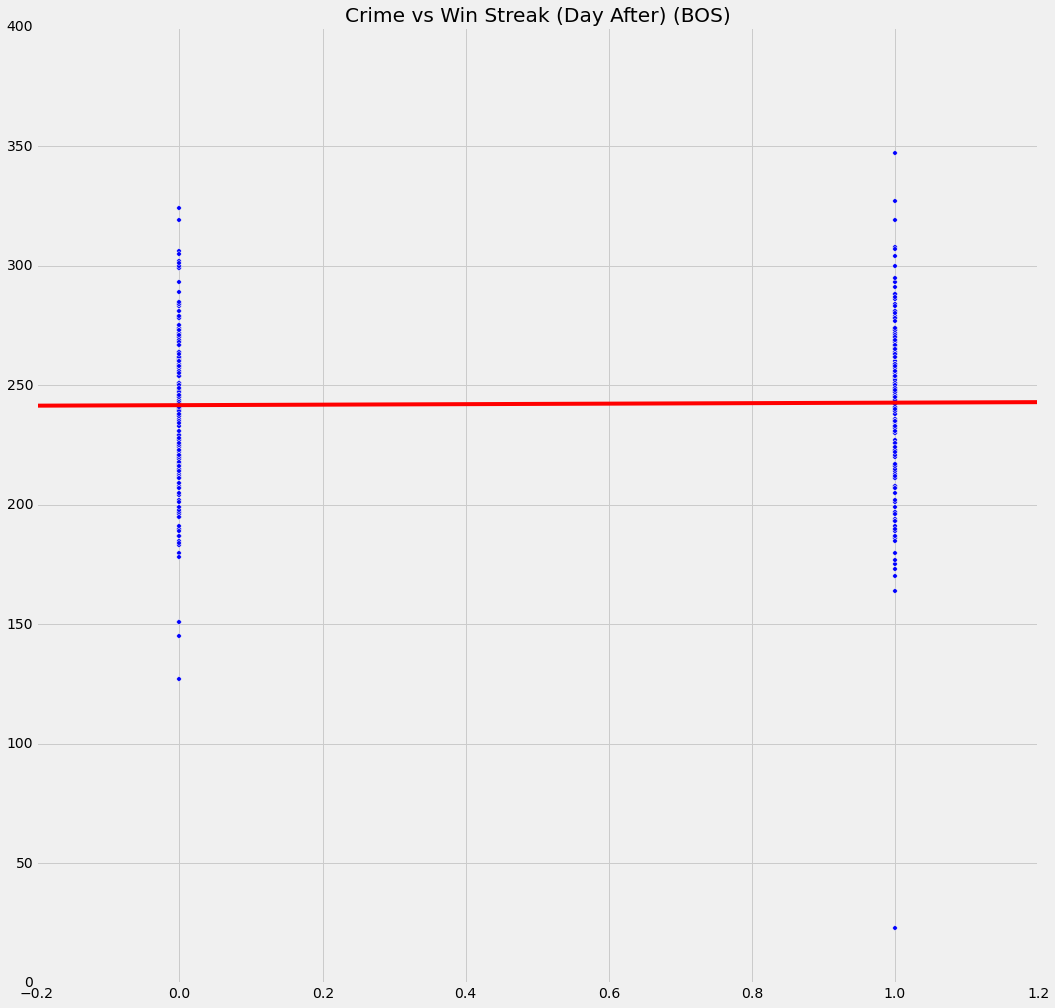

In [71]:
merged = pd.merge(df, crimes, on='Date')
grouped = merged.groupby('Date')
streak = []
counts = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).wl.iloc[0])
    counts.append(grouped.get_group(d).count()['NatureCode'])
    
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('Crime vs Win Streak (Day After) (BOS)')